In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Mask R-CNN - Train on Jalbert Dataset


In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [1]:
import jalbert
config = jalbert.jalbertConfig()


train=True


dim = 512

data_folder = "/dds/work/workspace/data_ja/"
groundtruth_path='/dds/work/workspace/data_ja/RF-CAT1-v1.0.csv'

scales = [0.8, 1., 1.25]

splits = ["all"]
# splits = ["train"]
# splits = ["test"]
# splits = ["test","train"]

In [3]:
if "all" in splits:
    dataset = jalbert.jalbertDataset()
    dataset.load_jalbert(dim, data_folder,groundtruth_path, scales)#, force_new_dataset=True)
    dataset.prepare()
    print("Image Count: {}".format(len(dataset.image_ids)))
    print("Class Count: {}".format(dataset.num_classes))
    for i, info in enumerate(dataset.class_info):
        print("{:3}. {:50}".format(i, info['name']))

ppm conversion: 100%|█| 44/44 [00:00<00:00, 381300.36it/s]

Loading from precedent scan
Image Count: 364
Class Count: 2
  0. BG                                                
  1. label                                             


In [9]:
nb_img = dataset.num_images
split_train = slice(1,2*nb_img//3)
split_val = slice(2*nb_img//3,nb_img)

dataset_train = jalbert.copydataset(dataset,split_train)
dataset_val = jalbert.copydataset(dataset,split_val)

print("Train")
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

print("Val")
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Train
Image Count: 241
Class Count: 2
  0. BG                                                
  1. label                                             
Val
Image Count: 122
Class Count: 2
  0. BG                                                
  1. label                                             


In [10]:
#config.IMAGES_PER_GPU = 2
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           jalbert
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING

In [13]:
if train:
    # Load and display random samples
    image_ids = np.random.choice(dataset_train.image_ids, 3)
    for image_id in image_ids:
        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

NameError: name 'np' is not defined

## Create Model

In [9]:
if train:
    # Create model in training mode
    model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
if train:
    # Which weights to start with?
    init_with = "imagenet"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
if train :
    # Train the head branches
    # Passing layers="heads" freezes all layers except the head
    # layers. You can also pass a regular expression to select
    # which layers to train by name pattern.
    model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE, 
                epochs=3, 
                layers='heads')

In [12]:
if train :
    # Fine tune all layers
    # Passing layers="all" trains all layers. You can also 
    # pass a regular expression to select which layers to
    # train by name pattern.
    model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE / 10,
                epochs=1, 
                layers="all")

In [13]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_jalbert_all.h5")
#model.keras_model.save_weights(model_path)
# print(model_path)

## Detection

In [14]:
class InferenceConfig(jalbert.jalbertConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_jalbert_all.h5")

# model_path = '/dds/work/workspace/Mask_RCNN/logs/jalbert20180310T2026/mask_rcnn_jalbert_0005.h5'
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /dds/work/workspace/Mask_RCNN/logs/jalbert20180311T2048/mask_rcnn_jalbert_0010.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:    0.00000  max:   46.00000
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000


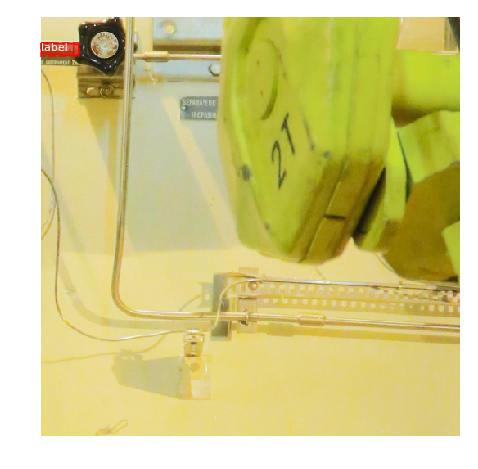

In [20]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


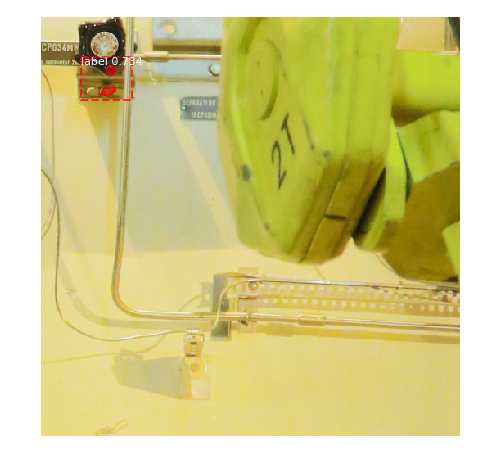

In [21]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [17]:
from tqdm import tnrange, tqdm_notebook
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
nb_test_images = len(dataset_val.image_ids)
print("testing on "+str(nb_test_images)+" images...")
image_ids = np.random.choice(dataset_val.image_ids, nb_test_images)
APs = []
match_counts = []
pred_counts = []
gt_boxes_counts = []
for image_id in tqdm_notebook(image_ids):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    
    match_count, pred_count, gt_boxes_count = utils.jg_compute_scores(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    match_counts.append(match_count)
    pred_counts.append(pred_count)
    gt_boxes_counts.append(gt_boxes_count)
    
print("mAP: ", np.mean(APs))
print("match_count: ", np.sum(match_counts))
print("pred_count: ", np.sum(pred_counts))
print("gt_boxes_count: ", np.sum(gt_boxes_counts))
print("precision: ", np.sum(match_counts)/np.sum(pred_counts))
print("recall: ", np.sum(match_counts)/np.sum(gt_boxes_counts))
print("Over.")

testing on 26 images...

mAP:  0.269230769231
match_count:  9
pred_count:  19
gt_boxes_count:  31
precision:  0.473684210526
recall:  0.290322580645
Over.
